### Configuration

In [2]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
#from pyspark.ml.feature import StandardScaler
from sklearn.preprocessing import StandardScaler
from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.clustering import KMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyspark.sql.types import *
import sys
import os
import matplotlib.pyplot as plt
import psutil
import random
import numpy as np
import seaborn as sns
from scipy.spatial import Voronoi, voronoi_plot_2d



In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("krishsharma0413/2-million-songs-from-mpd-with-audio-features")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\m.varo\.cache\kagglehub\datasets\krishsharma0413\2-million-songs-from-mpd-with-audio-features\versions\1


In [4]:
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['extracted.db']


In [5]:
print("Dataset path:", path)

Dataset path: C:\Users\m.varo\.cache\kagglehub\datasets\krishsharma0413\2-million-songs-from-mpd-with-audio-features\versions\1


In [6]:
db_path = os.path.join(path, "extracted.db")  # Ensure correct file path

if os.path.exists(db_path):
    print("Database file found:", db_path)
else:
    print("Database file NOT found. Check the path:", db_path)

Database file found: C:\Users\m.varo\.cache\kagglehub\datasets\krishsharma0413\2-million-songs-from-mpd-with-audio-features\versions\1\extracted.db


In [7]:
import sqlite3

# Connect to the database
conn = sqlite3.connect(db_path)

# Create a cursor object
cursor = conn.cursor()

# List all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in database:", tables)

Tables in database: [('extracted',)]


In [8]:
# Replace 'your_table_name' with an actual table name
table_name = "extracted"

# Read table into a Pandas DataFrame
df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Display first few rows
print(df.head())

                              track_uri  \
0  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI   
1  spotify:track:6I9VzXrHxO9rA9A5euc8Ak   
2  spotify:track:0WqIKmW4BTrj3eJFmnCKMv   
3  spotify:track:1AWQoqb9bSvzTjaLralEkT   
4  spotify:track:1lzr43nnXAijIGYnCT8M8H   

                                   track_name        artist_name  \
0  Lose Control (feat. Ciara & Fat Man Scoop)      Missy Elliott   
1                                       Toxic     Britney Spears   
2                               Crazy In Love            Beyoncé   
3                              Rock Your Body  Justin Timberlake   
4                                It Wasn't Me             Shaggy   

                              artist_uri  \
0  spotify:artist:2wIVse2owClT7go1WT98tk   
1  spotify:artist:26dSoYclwsYLMAKD3tpOr4   
2  spotify:artist:6vWDO969PvNqNYHIOW5v0m   
3  spotify:artist:31TPClRtHm23RisEBtV3X7   
4  spotify:artist:5EvFsr3kj42KNv97ZEnqij   

                                     album_name  \
0               

In [9]:
print(df.info())  # Check column types
print(df.describe())  # Summary statistics
print(df.isnull().sum())  # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2261644 entries, 0 to 2261643
Data columns (total 25 columns):
 #   Column            Dtype  
---  ------            -----  
 0   track_uri         object 
 1   track_name        object 
 2   artist_name       object 
 3   artist_uri        object 
 4   album_name        object 
 5   album_uri         object 
 6   duration_ms       int64  
 7   danceability      float64
 8   energy            float64
 9   key               int64  
 10  loudness          float64
 11  mode              int64  
 12  speechiness       float64
 13  acousticness      float64
 14  instrumentalness  float64
 15  liveness          float64
 16  valence           float64
 17  tempo             float64
 18  type              object 
 19  id                object 
 20  uri               object 
 21  track_href        object 
 22  analysis_url      object 
 23  fduration_ms      int64  
 24  time_signature    int64  
dtypes: float64(9), int64(5), object(11)
memory us

In [10]:
df.head()

,track_uri,track_name,artist_name,artist_uri,album_name,album_uri,duration_ms,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,fduration_ms,time_signature
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,0.904,0.813,4,...,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,0.774,0.838,5,...,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,0.664,0.759,2,...,0.0598,0.701,99.252,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,0.892,0.714,4,...,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,0.853,0.606,0,...,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4


In [11]:
# Drop non-numeric columns (adjust as needed)
df_numeric = df.select_dtypes(include=['number'])

In [12]:
df_numeric.fillna(df_numeric.mean(), inplace=True)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

In [14]:
df.columns

Index(['track_uri', 'track_name', 'artist_name', 'artist_uri', 'album_name',
       'album_uri', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'fduration_ms', 'time_signature'],
      dtype='object')

In [15]:
df_scaled.shape

(2261644, 14)

In [16]:
X_rank = np.linalg.matrix_rank(df_scaled)
print('Rank of X_train:', X_rank)
K_linspace = np.linspace(1, 0.75 * X_rank, 10, dtype=int)
Ks = np.unique( K_linspace)

RMSE_train = np.arange(len(Ks))

Ks 

Rank of X_train: 14


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

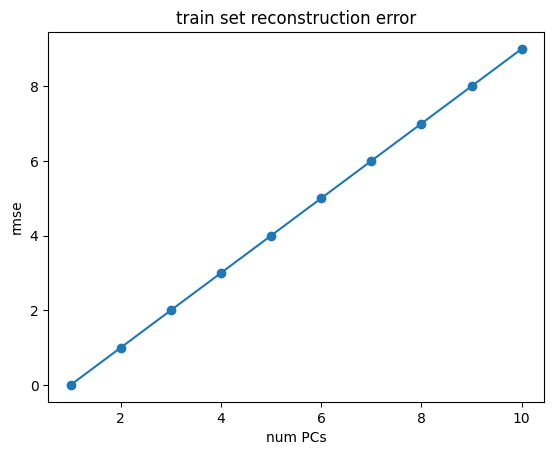

In [17]:
import matplotlib.pyplot as plt

# Fraction of variance explained
pca = PCA(n_components=X_rank)
X_transformed = pca.fit_transform(df_numeric)
evals = pca.explained_variance_  # eigenvalues in descending order

fraction_var = np.cumsum(evals[0:50] / np.sum(evals))

fig, ax = plt.subplots()
xs = Ks
ys = RMSE_train
plt.title("train set reconstruction error")
plt.xlabel("num PCs")
plt.ylabel("rmse")
ax.plot(xs, ys, marker="o")
plt.show()

In [18]:
from sklearn.decomposition import PCA

# Choose number of components (e.g., 2 for visualization)
pca = PCA(n_components=4)

# Fit and transform the data
pca_result = pca.fit_transform(df_scaled)

# Convert back to DataFrame
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4'])


In [19]:
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

Explained Variance Ratio: [0.22856073 0.14648429 0.08934115 0.08574288]


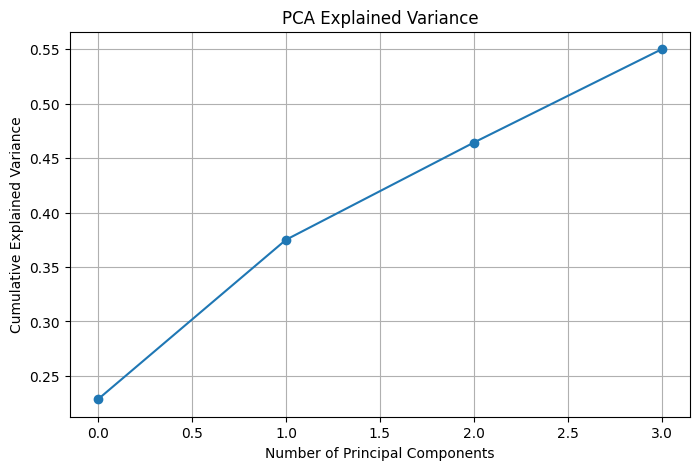

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Plot variance explained
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

In [21]:
df.columns

Index(['track_uri', 'track_name', 'artist_name', 'artist_uri', 'album_name',
       'album_uri', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'fduration_ms', 'time_signature'],
      dtype='object')

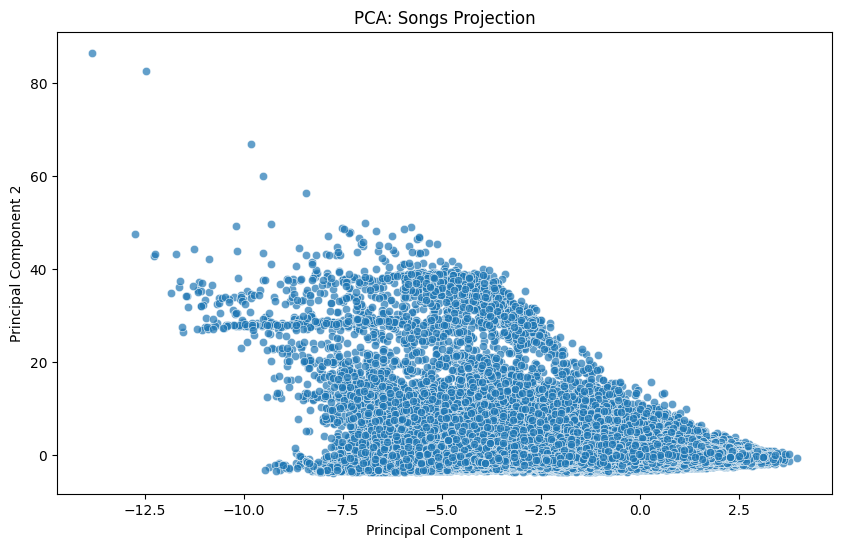

In [22]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Songs Projection')
plt.show()

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Use PCA-transformed data (PC1, PC2)
X = df_pca[['PC1', 'PC2']]

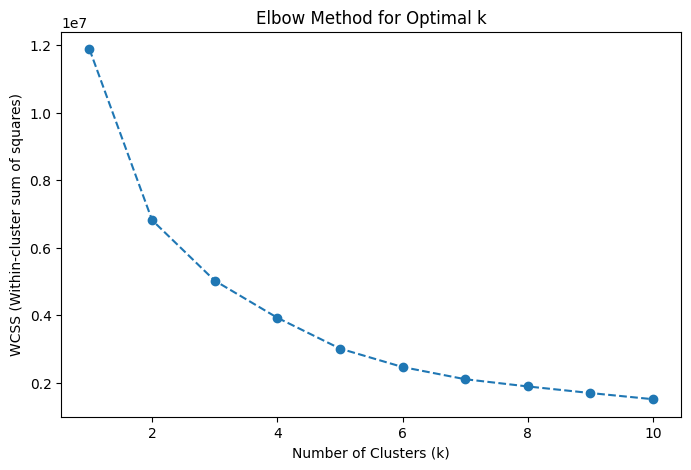

In [24]:
wcss = []  # Within-cluster sum of squares

for k in range(1, 11):  # Try k values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-cluster sum of squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [25]:
optimal_k = 4  # Change this based on elbow method results

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans.fit_predict(X)

# Centroids
centroids = kmeans.cluster_centers_

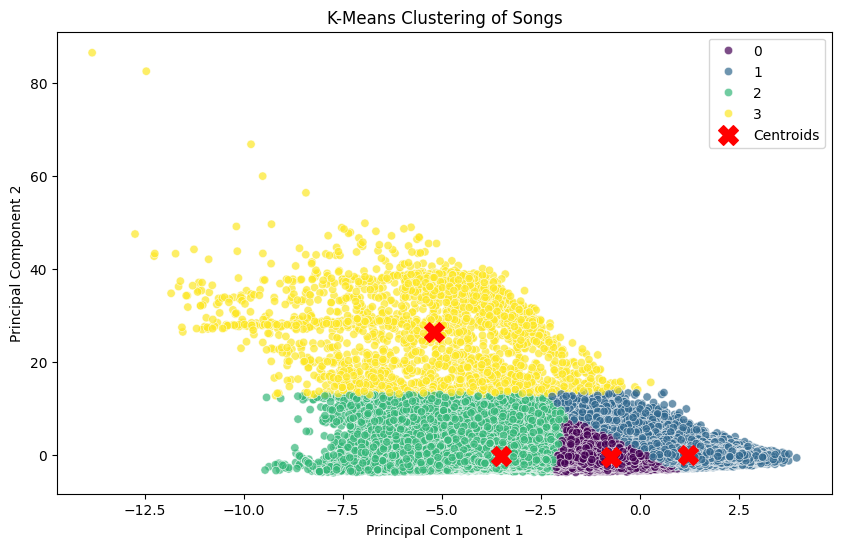

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['Cluster'], palette='viridis', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Songs')
plt.legend()
plt.show()

In [27]:
df.columns

Index(['track_uri', 'track_name', 'artist_name', 'artist_uri', 'album_name',
       'album_uri', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'fduration_ms', 'time_signature'],
      dtype='object')

In [28]:
# Show 10 random songs per cluster
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(df.loc[df_pca['Cluster'] == i, ['track_name', 'artist_name']].sample(10))



Cluster 0:
                                                track_name  \
923873                                                親朋勿友   
854154   Estimated Prophet - Live at the Capital Center...   
309437                                              Golden   
721056                                               Needs   
267414                  Be My Lady - Telesereye Theme Song   
1208587                           Don't Wanna Lose You Yet   
2097789                                    Stenhammrah Dub   
706555             Messiah, HWV 56 / Pt. 2: 42. Hallelujah   
626943                                     Basically Older   
1599904                                      Surin (mixed)   

                    artist_name  
923873              Stephy Tang  
854154            Grateful Dead  
309437      Danger Incorporated  
721056         THEESatisfaction  
267414                 Jason Dy  
1208587                 Bertolf  
2097789   Pockets Of Resistance  
706555   George Frideric Handel  

In [29]:
# Show 10 random songs per cluster
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(df.loc[df_pca['Cluster'] == i, ['track_name', 'artist_name']].sample(10))



Cluster 0:
                                          track_name  \
99403                          Happy Birthday, Julie   
645129                      Landslide (Stevie Nicks)   
2205861                                    Back Back   
363436                                     Plug Name   
2097107  Next Time Wipe The Lipstick Off Your Collar   
2176212                      Also sprach Zarathustra   
1774166                                  heardyousay   
540219                                Fado das horas   
1890660                                          芳草地   
340243                             Ain't Misbehavin'   

                       artist_name  
99403                Wayne Hancock  
645129                Michael Marc  
2205861               Archie Shepp  
363436                      Berner  
2097107                  Sheila E.  
2176212                    Deodato  
1774166  eli filosov [ p h i l o ]  
540219     Maria Teresa De Noronha  
1890660                         陳粒  
3

---

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Use PCA-reduced data (PC1, PC2) OR the original scaled features
X = df_scaled  # Use standardized full dataset for better representation


# Set sample size (adjust as needed)
sample_size = 10000  

# Randomly sample without replacement
df_sample = df_numeric.sample(sample_size, random_state=42)

# Standardize the sample
df_sample_scaled = scaler.fit_transform(df_sample)

In [31]:
# Initialize and apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # Adjust perplexity if needed
X_tsne = tsne.fit_transform(df_sample_scaled)

# Convert to DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['track_name'] = df['track_name']  # Optional: Add song names for reference
df_tsne['artist_name'] = df['artist_name']  # Optional: Add artist names


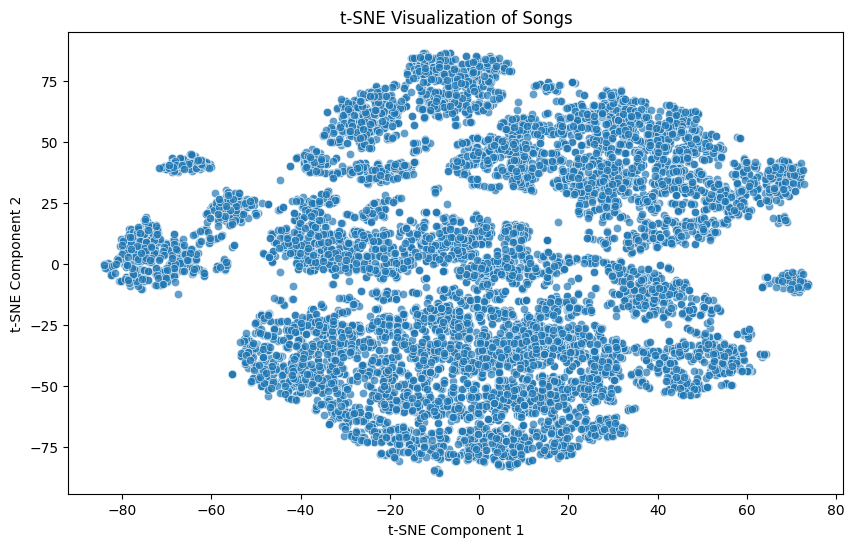

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_tsne['TSNE1'], y=df_tsne['TSNE2'], alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Songs')
plt.show()


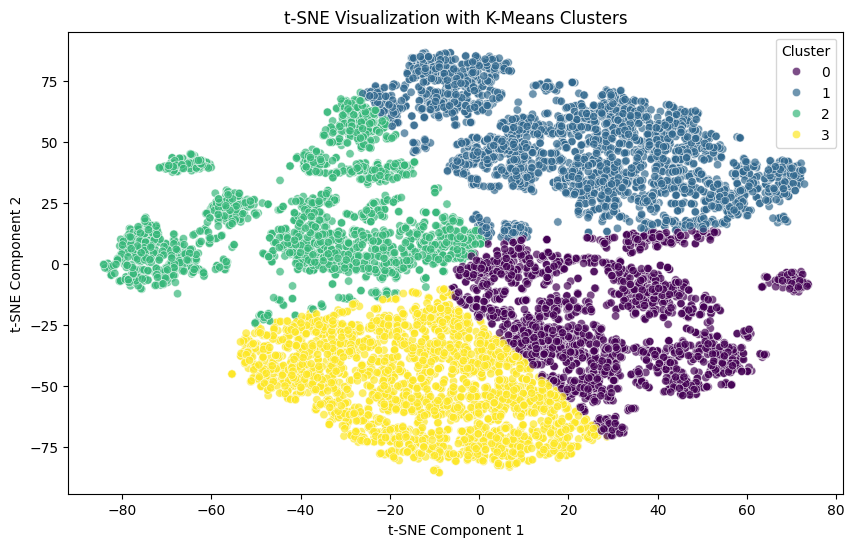

In [33]:
from sklearn.cluster import KMeans

# Choose optimal k (from previous Elbow Method)
optimal_k = 4

# Apply K-Means on t-SNE output
kmeans_tsne = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_tsne['Cluster'] = kmeans_tsne.fit_predict(X_tsne)

# Plot t-SNE with Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_tsne['TSNE1'], y=df_tsne['TSNE2'], hue=df_tsne['Cluster'], palette='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization with K-Means Clusters')
plt.legend(title='Cluster')
plt.show()


In [34]:
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(df_tsne[df_tsne['Cluster'] == i][['song_name', 'artist_name']].sample(10))



Cluster 0:


KeyError: "['song_name'] not in index"